# Pendulum Equation Comparison: PINN vs RK4 vs Exact

https://github.com/fancifulcrow/PINN/blob/main/harmonic_oscillator.ipynb

In [2]:
import numpy as np
import math
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import grad
import matplotlib.pyplot as plt

In [ ]:
# -----------------------------------------------------------------------------
# 1) Problem Parameters
# -----------------------------------------------------------------------------
g        = 9.81
L        = 1.0
damping  = 0.5
θ0       = 0.5        # initial angle (small‐angle)
t_min    = 0.0
t_max    = 5.0

# -----------------------------------------------------------------------------
# 2) Exact small‐angle solution (for supervised data generation)
# -----------------------------------------------------------------------------
def exact_small_angle(t, θ0=θ0, g=g, L=L, d=damping):
    ωd2 = max(g/L - (d/2)**2, 0.0)
    ωd  = math.sqrt(ωd2)
    return θ0 * np.exp(-d*t/2) * np.cos(ωd * t)

# -----------------------------------------------------------------------------
# 3) RK4 integrator for the full nonlinear damped pendulum
# -----------------------------------------------------------------------------
class SinglePendulumRK4:
    def __init__(self, g, L, d, θ0, dt=1e-3, t_max=30.0):
        self.g, self.L, self.d = g, L, d
        self.θ0 = θ0
        self.dt = dt
        self.t_max = t_max

    def solve(self, times):
        times_sorted = sorted(times)
        hist = {}
        idx = 0
        next_t = times_sorted[idx]

        θ = self.θ0
        ω = 0.0
        t = 0.0
        steps = int(self.t_max/self.dt) + 1

        for _ in range(steps):
            if t >= next_t - self.dt/2:
                hist[next_t] = θ
                idx += 1
                if idx == len(times_sorted):
                    break
                next_t = times_sorted[idx]

            # RK4 step
            def deriv(θ, ω):
                return ω, -self.d*ω - (self.g/self.L)*math.sin(θ)

            k1θ, k1ω = deriv(θ, ω)
            k2θ, k2ω = deriv(θ + 0.5*self.dt*k1θ, ω + 0.5*self.dt*k1ω)
            k3θ, k3ω = deriv(θ + 0.5*self.dt*k2θ, ω + 0.5*self.dt*k2ω)
            k4θ, k4ω = deriv(θ +     self.dt*k3θ, ω +     self.dt*k3ω)

            θ += (self.dt/6)*(k1θ + 2*k2θ + 2*k3θ + k4θ)
            ω += (self.dt/6)*(k1ω + 2*k2ω + 2*k3ω + k4ω)
            t += self.dt

        return hist

# -----------------------------------------------------------------------------
# 4) PINN: Fourier‐SIREN embedding + MLP
# -----------------------------------------------------------------------------
class TimeFourier(nn.Module):
    def __init__(self, in_dim=1, mapping_size=256, scale=10.0):
        super().__init__()
        B = torch.randn(in_dim, mapping_size) * scale
        self.register_buffer('B', B)

    def forward(self, t):
        # t: [N,1]
        proj = 2*math.pi * t @ self.B      # [N, mapping_size]
        return torch.cat([torch.sin(proj), torch.cos(proj)], dim=-1)
    

class PINNPendODE(nn.Module):
    def __init__(self, g=9.81, L=1.0, d=0.1,
                 t_max:float=30.0,
                 fourier_features:int=128,
                 hidden=[512,256]):
        super().__init__()
        self.g, self.L, self.d, self.t_max = g, L, d, t_max
        # Fourier embedding of time
        self.ff   = TimeFourier(1, fourier_features, scale=10)
        # SIREN‐style first layer
        self.lin0 = nn.Linear(2*fourier_features, hidden[0])
        self.ω0   = self.t_max
        # remaining MLP
        layers = []
        for i in range(len(hidden)-1):
            layers += [nn.Linear(hidden[i], hidden[i+1]), nn.Tanh()]
        layers += [nn.Linear(hidden[-1], 1)]
        self.net = nn.Sequential(*layers)

        # ----- custom weight initialization -----
        # 1) SIREN init for the first linear:
        with torch.no_grad():
            fan_in = self.lin0.weight.size(1)
            bound = 1.0 / fan_in
            self.lin0.weight.uniform_(-bound, bound)
            self.lin0.bias.uniform_(-bound, bound)

        # 2) Xavier init for all other Linear layers:
        for m in self.net:
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.zeros_(m.bias)

    def forward(self, t):
        # (optional) normalize t to [–1,1] first
        t_norm = 2*(t/self.t_max) - 1
        φ = self.ff(t_norm)  # [N,2M]
        h = torch.sin(self.ω0*self.lin0(φ)) # SIREN activation [N,1]
        y = self.net(h)          # now y≈cos(ω_d t)
        return torch.exp(-self.d*t/2)*y

    def loss_pde(self, t):
        t = t.clone().detach().requires_grad_(True)
        u   = self.forward(t)
        u_t = grad(u, t, grad_outputs=torch.ones_like(u), create_graph=True)[0]
        u_tt= grad(u_t, t, grad_outputs=torch.ones_like(u_t), create_graph=True)[0]
        # residual: u_tt + d u_t + (g/L) sin(u) = 0
        res = u_tt + self.d*u_t + (self.g/self.L)*torch.sin(u)
        return torch.mean(res**2)

    def loss_ic(self, θ0_val=θ0):
        dev = next(self.parameters()).device
        t0  = torch.zeros(1, 1, device=dev, requires_grad=True)
        u0 = self.forward(t0)
        return (u0 - θ0_val)**2

# -----------------------------------------------------------------------------
# 5) Training: phase 1 = Adam + LR scheduler (with extra early-time data)
# -----------------------------------------------------------------------------
device = torch.device('mps')
pinn   = PINNPendODE(g, L, damping, t_max).to(device)
opt    = optim.Adam(pinn.parameters(), lr=5e-5)
sched  = optim.lr_scheduler.StepLR(opt, step_size=2000, gamma=0.05)

w_pde, w_ic, w_data = 5.0, 5.0, 8.0
N_pde, N_data       = 4000, 4000

# 5.1) Uniform supervised data over [0, t_max]
t_data = torch.linspace(t_min, t_max, N_data, device=device).unsqueeze(-1)  # shape (N_data,1)
u_data = torch.tensor(
    exact_small_angle(t_data.cpu().numpy())[:, None],
    dtype=torch.float32,
    device=device
)  # shape (N_data,1)

# 5.2) Extra “anchor” points in [0, 5] to nail the envelope
t_extra = torch.rand(200, 1, device=device) * 20.0                           # shape (200,1)
u_extra = torch.tensor(
    exact_small_angle(t_extra.cpu().numpy())[:, None],
    dtype=torch.float32,
    device=device
)  # shape (200,1)

# 5.3) Combine and shuffle
t_data = torch.cat([t_data, t_extra], dim=0)  # now (8200,1)
u_data = torch.cat([u_data, u_extra], dim=0)

perm   = torch.randperm(t_data.size(0), device=device)
t_data = t_data[perm]
u_data = u_data[perm]

# 5.4) Training loop
for ep in range(1, 15001):
    # curriculum on w_pde
    w_pde = 0.1 + 9.9 * min(ep/1000, 1.0)

    # PDE collocation loss
    t_pde = torch.rand(N_pde,1, device=device) * t_max
    lpde  = pinn.loss_pde(t_pde)

    # IC loss
    lic   = pinn.loss_ic()

    # Data-MSE loss
    upred = pinn(t_data)
    ldat  = nn.MSELoss()(upred, u_data)

    # Total loss
    loss = w_pde*lpde + w_ic*lic + w_data*ldat

    opt.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(pinn.parameters(), max_norm=1.0)
    opt.step()
    sched.step()

    if ep % 1000 == 0:
        print(f"Epoch {ep}: PDE={lpde.item():.2e}, IC={lic.item():.2e}, DATA={ldat.item():.2e}")


# -----------------------------------------------------------------------------
# 6) Training: phase 2 = L-BFGS refinement
# -----------------------------------------------------------------------------
print("Starting L-BFGS refinement…")
# move model and data to CPU
pinn_cpu   = pinn.cpu()
t_data_cpu = t_data.cpu()
u_data_cpu = u_data.cpu()

lbfgs = torch.optim.LBFGS(
    pinn_cpu.parameters(),
    lr=1.0,
    max_iter=500,
    tolerance_grad=1e-8,
    line_search_fn='strong_wolfe'
)

def closure():
    lbfgs.zero_grad()
    # Sample PDE collocation points on CPU
    t_pde_cpu = torch.rand(N_pde, 1) * t_max  # default dtype and device=CPU
    lpde  = pinn_cpu.loss_pde(t_pde_cpu)
    lic   = pinn_cpu.loss_ic()
    # Data loss on CPU
    upred = pinn_cpu(t_data_cpu)
    ldat  = nn.MSELoss()(upred, u_data_cpu)
    # Combine all losses with the same weights used in phase 1
    loss = w_pde * lpde + w_ic * lic + w_data * ldat
    loss.backward()
    return loss

final_loss = lbfgs.step(closure)
print("L-BFGS final loss:", final_loss.item())

# -----------------------------------------------------------------------------
# 7) Evaluate & plot line traces
# -----------------------------------------------------------------------------
pinn.eval()
t_vals = np.linspace(t_min, t_max, 1000)
U_ex   = exact_small_angle(t_vals)
rk4    = SinglePendulumRK4(g, L, damping, θ0, dt=1e-3, t_max=t_max)

dt      = 1e-3
ts      = np.arange(0, t_max+dt, dt)
hist    = rk4.solve(ts.tolist())
θ_vals  = np.array([hist[t] for t in ts])
U_fd    = np.interp(t_vals, ts, θ_vals)

with torch.no_grad():
    tt_cpu = torch.tensor(t_vals[:, None], dtype=torch.float32)
    U_pr = pinn(tt_cpu).cpu().numpy().flatten()

plt.figure(figsize=(8,4))
plt.plot(t_vals, U_ex, 'k--', lw=2, label=r'Exact $\theta_0 = 0.5$')
plt.plot(t_vals, U_fd, 'b-',  label='RK4')
plt.plot(t_vals, U_pr, 'rx',  label='PINN', alpha=0.4)
plt.xlabel('t'); plt.ylabel(r'$\theta(t)$')
plt.legend(); plt.grid(True)
plt.tight_layout()
plt.show()

/Users/josegarcia/Documents/Cursor/PINNs-RL-PDE/pinn/lib/python3.13/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([4200, 1, 1])) that is different to the input size (torch.Size([4200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1000: PDE=1.60e+01, IC=1.27e-02, DATA=6.75e-02
Epoch 2000: PDE=9.09e+00, IC=1.36e-02, DATA=6.82e-02
Epoch 3000: PDE=2.62e-02, IC=1.13e-02, DATA=6.92e-02
Epoch 4000: PDE=1.58e-02, IC=1.11e-02, DATA=6.93e-02
Epoch 5000: PDE=1.72e-03, IC=1.11e-02, DATA=6.93e-02
Epoch 6000: PDE=1.67e-03, IC=1.11e-02, DATA=6.93e-02
Epoch 7000: PDE=1.56e-03, IC=1.11e-02, DATA=6.93e-02


In [1]:
plt.figure(figsize=(8,4))
plt.plot(t_vals, U_ex, 'k--', lw=2, label=r'Exact $\theta_0 = 0.5$')
plt.plot(t_vals, U_fd, 'b-',  label='RK4')
plt.plot(t_vals, U_pr, 'rx',  label='PINN', alpha=0.4)
plt.xlabel('t'); plt.ylabel(r'$\theta(t)$')
plt.legend(); plt.grid(True)
plt.tight_layout()
plt.title("Nonlinear Damped Pendulum Equation")
plt.show()

NameError: name 'plt' is not defined

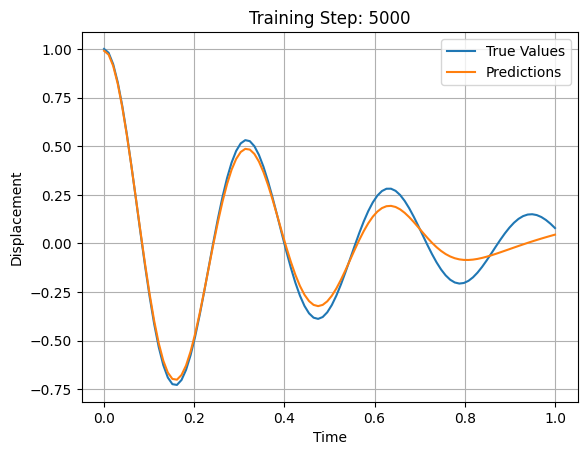

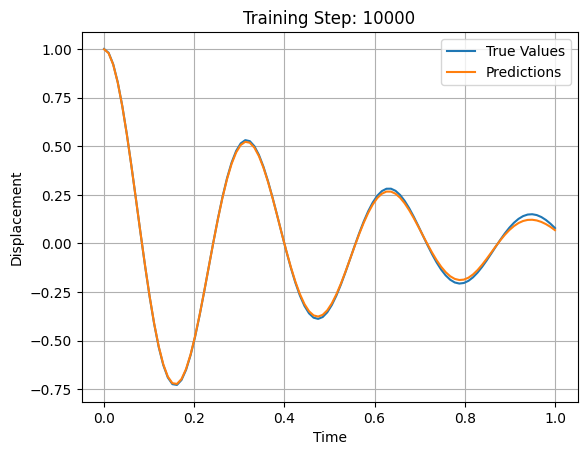

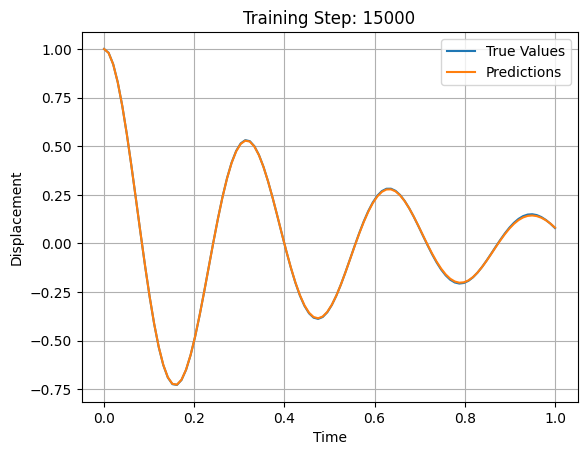

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt



def displacement(t:np.ndarray, delta:float, omega_0:float,) -> np.ndarray:
    omega = np.sqrt(omega_0**2 - delta**2)

    phi = np.arctan(-delta / omega)
    A = 1 / (2 * np.cos(phi))
    
    return 2 * A * np.exp(-delta * t) * np.cos(omega * t + phi)


class Model(nn.Module):
    def __init__(self, in_channels:int, out_channels:int, hidden_channels:int, num_hidden_layers:int=2) -> None:
        super().__init__()

        self.input_layer = nn.Linear(in_channels, hidden_channels)

        self.hidden_layers = nn.ModuleList([
            nn.Linear(hidden_channels, hidden_channels)for _ in range(num_hidden_layers)
        ])

        self.output_layer = nn.Linear(hidden_channels, out_channels)


    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = F.tanh(self.input_layer(x))
        
        for hidden_layer in self.hidden_layers:
            x = F.tanh(hidden_layer(x))

        x = self.output_layer(x)

        return x
    

d = 2
w0 = 20
m = 1

c = d * 2 * m
k = (w0**2) * m 

# time values for the interval [0, 10]
t_physics = np.linspace(0, 1, 100)
y_physics = displacement(t_physics, d, w0)

t_physics = torch.tensor(t_physics, dtype=torch.float32).view(-1,1).requires_grad_(True)
y_physics = torch.tensor(y_physics, dtype=torch.float32).view(-1,1).requires_grad_(True)

# t = 0
t_boundary = torch.tensor(0.).view(-1,1).requires_grad_(True)

# weighting factors
lambda_1, lambda_2 = 1e-1, 1e-4

pinn = Model(1, 1, 32)
optimiser = optim.Adam(pinn.parameters(), lr=1e-3)

num_training_steps = 15000
for training_step in range(num_training_steps):
    optimiser.zero_grad()

    # First Boundary Loss
    y = pinn(t_boundary)
    loss1 = (torch.squeeze(y) - 1)**2

    # Second Boundary Loss
    dy_dt = torch.autograd.grad(y, t_boundary, torch.ones_like(y), create_graph=True)[0]
    loss2 = (torch.squeeze(dy_dt) - 0)**2
    
    # Physics Loss
    y = pinn(t_physics)
    dy_dt = torch.autograd.grad(y, t_physics, torch.ones_like(y), create_graph=True)[0]
    d2y_dt2 = torch.autograd.grad(dy_dt, t_physics, torch.ones_like(dy_dt), create_graph=True)[0]
    loss3 = torch.mean((m * d2y_dt2 + c * dy_dt + k * y)**2)
    
    # Total Loss
    loss = loss1 + lambda_1 * loss2 + lambda_2 * loss3

    loss.backward()
    optimiser.step()

    if (training_step + 1) % 5000 == 0:
        plt.plot(t_physics.detach().numpy(), y_physics.detach().numpy(), label="True Values")
        plt.plot(t_physics.detach().numpy(), pinn(t_physics).detach().numpy(), label="Predictions")
        plt.xlabel("Time")
        plt.ylabel("Displacement")
        plt.title(f"Training Step: {training_step + 1}")
        plt.legend()
        plt.grid(True)
        plt.show()

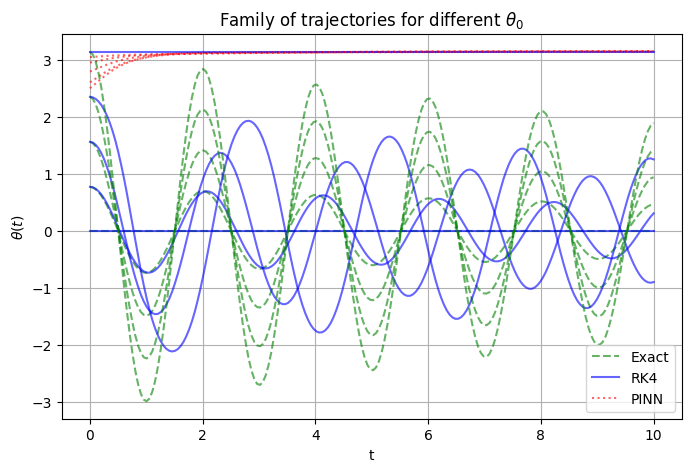

In [22]:
# pick a handful of initial‐angles to show, e.g. 5 evenly spaced:
n_plots = 5
idxs = np.linspace(0, Nθ-1, n_plots, dtype=int)

fig, ax = plt.subplots(figsize=(8,5))
for idx in idxs:
    label = fr"$\theta_0={θ0_vals[idx]:.2f}$"
    ax.plot(t_vals,  U_ex[idx,:],  'g--', alpha=0.6, label="Exact" if idx==idxs[0] else None)
    ax.plot(t_vals,  U_fd[idx,:],  'b-',  alpha=0.6, label="RK4" if idx==idxs[0] else None)
    ax.plot(t_vals,  U_pr[idx,:],  'r:', alpha=0.6, label="PINN"    if idx==idxs[0] else None)

ax.set_xlabel("t")
ax.set_ylabel(r"$\theta(t)$")
ax.set_title(r"Family of trajectories for different $\theta_{0}$")
ax.grid(True)
ax.legend()
plt.show()